## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

* кошки (животные)
* UNIX-утилита cat для вывода содержимого файлов
* версии операционной системы OS X, названные в честь семейства кошачьих

Задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу будем использовать косинусное расстояние.

In [1]:
import re
import numpy as np
from scipy.spatial import distance

Считаем файл

In [2]:
with open('sentences.txt', 'r') as data:
    sentences = data.readlines()

Приведём каждую строчку к нижнему регистру с помощью строковой функции lower()

In [3]:
sentences = [text.lower() for text in sentences]

Произведём токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Удалим пустые слова после разделения

In [4]:
tokenized_sent = [[word for word in re.split('[^a-z]', text) if word != ''] for text in sentences]

Составим список всех слов, встречающихся в предложениях. Сопоставим каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях.

In [5]:
words = {}
i = 0
for text in tokenized_sent:
    for word in text:
        if word not in words:
            words[word] = i
            i += 1

Создадим матрицу размера n * d, где n — число предложений. Заполним её: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. Должна получиться матрица размера 22 * 254.

In [6]:
sent_words = np.zeros((22, 254))
for i, text in enumerate(tokenized_sent):
    for word in text:
        sent_words[i][words[word]] += 1

Найдём косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine.

In [7]:
cosine_distances = []
for sent in sent_words:
    cosine_distances.append(distance.cosine(sent_words[0], sent))

Получим отсортированный список индексов предложений ближайших к первому по косинусному расстоянию.

In [8]:
sorted_indexes = np.argsort(cosine_distances)
sorted_indexes

array([ 0,  6,  4, 21, 10, 12, 16, 20,  2, 13, 14, 11,  8, 19,  3,  9,  7,
        5, 15, 18,  1, 17])

In [9]:
print(f'Первое предложение ближайшее к первому {sorted_indexes[1]}, второе предложение ближайшее к первому {sorted_indexes[2]}')

Первое предложение ближайшее к первому 6, второе предложение ближайшее к первому 4


In [10]:
print('Исходное первое предложение:', sentences[0])
print('Первое предложение ближайшее к первому:', sentences[6])
print('Второе предложение ближайшее к первому:', sentences[4])

Исходное первое предложение: in comparison to dogs, cats have not undergone major changes during the domestication process.

Первое предложение ближайшее к первому: domestic cats are similar in size to the other members of the genus felis, typically weighing between 4 and 5 kg (8.8 and 11.0 lb).

Второе предложение ближайшее к первому: in one, people deliberately tamed cats in a process of artificial selection, as they were useful predators of vermin.



Видно, что предложения действительно схожи по тематике и объединены "кошачьей темой" в одном смысле: кошки (животные).

## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке $[1, 15]$:

$$f(x) = \sin\frac{x}{5} \cdot e^{\frac{x}{10}} + 5 \cdot e^{\frac{-x}{2}}$$

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. Будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени $n$ (то есть $w_0 + w_1 x + w_2 x^2 + ... + w_n x^n$) однозначно определяется любыми $n + 1$ различными точками, через которые он проходит. Это значит, что его коэффициенты $w_0, ... w_n$ можно определить из следующей системы линейных уравнений:

$$\begin{cases}
w_0 + w_1 x_1 + w_2 x_1^2 + ... + w_n x_1^n = f(x_1) \\
\dots \\
w_0 + w_1 x_{n+1} + w_2 x_{n+1}^2 + ... + w_n x_{n+1}^n = f(x_{n+1}) \\
\end{cases}$$

где через $x_1, ..., x_n, x_{n+1}$ обозначены точки, через которые проходит многочлен, а через $f(x_1), ..., f(x_n), f(x_{n+1})$ — значения, которые он должен принимать в этих точках.

In [11]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

Определим нашу функцию.

In [12]:
def f(x):
    return np.sin(x / 5) * np.exp(x / 10) + 5 * np.exp(-x / 2)

Сформируем систему линейных уравнений (то есть зададим матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. 

In [13]:
a = np.array([[1, 1], [1, 15]])
b = np.array([f(1), f(15)])

w1 = linalg.solve(a, b)
w1

array([ 3.43914511, -0.18692825])

Определим получившийся многочлен

In [14]:
def result_function1(x):
    return w1[0] + w1[1] * x

Нарисуем функцию f и полученный многочлен. 

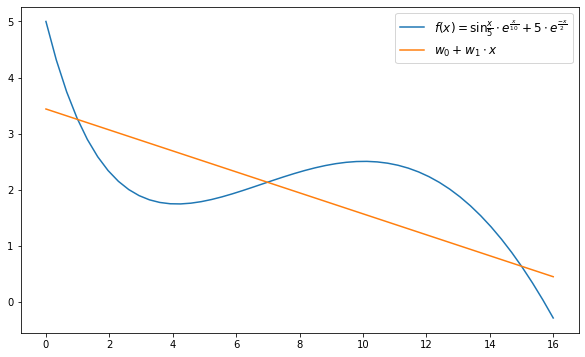

In [15]:
x = np.linspace(0, 16)
y1 = f(x)
y2 = result_function1(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label=r"$f(x) = \sin\frac{x}{5} \cdot e^{\frac{x}{10}} + 5 \cdot e^{\frac{-x}{2}}$")
plt.plot(x, y2, label=r"$w_0 + w_1 \cdot x$")
plt.legend(fontsize=12)
plt.show()

Видно, что получившийся многочлен первой степени плохо приближает исходную функцию.

Повторим те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15.

In [16]:
a = np.array([[1, 1, 1], [1, 8, 8**2], [1, 15, 15**2]])
b = np.array([f(1), f(8), f(15)])

w2 = linalg.solve(a, b)
w2

array([ 3.32512949, -0.06531159, -0.00760104])

In [17]:
def result_function2(x):
    return w2[0] + w2[1] * x + w2[2] * x**2

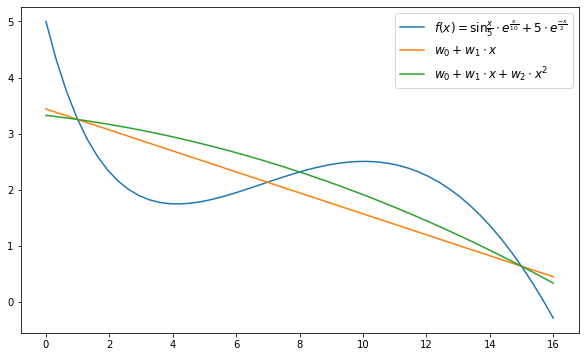

In [18]:
x = np.linspace(0, 16)
y1 = f(x)
y2 = result_function1(x)
y3 = result_function2(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label=r"$f(x) = \sin\frac{x}{5} \cdot e^{\frac{x}{10}} + 5 \cdot e^{\frac{-x}{2}}$")
plt.plot(x, y2, label=r"$w_0 + w_1 \cdot x$")
plt.plot(x, y3, label=r"$w_0 + w_1 \cdot x + w_2 \cdot x^2$")
plt.legend(fontsize=12)
plt.show()

Кажется, что качество аппроксимации не улучшилось.

Повторим те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15.

In [19]:
a = np.array([[1, 1, 1, 1], [1, 4, 4**2, 4**3], [1, 10, 10**2, 10**3], [1, 15, 15**2, 15**3]])
b = np.array([f(1), f(4), f(10), f(15)])

w3 = linalg.solve(a, b)
w3

array([ 4.36264154, -1.29552587,  0.19333685, -0.00823565])

In [20]:
def result_function3(x):
    return w3[0] + w3[1] * x + w3[2] * x**2 + w3[3] * x**3

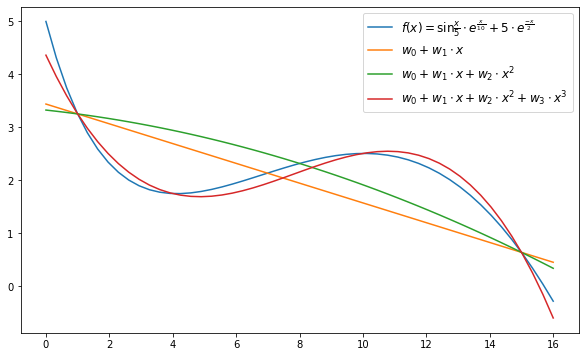

In [21]:
x = np.linspace(0, 16)
y1 = f(x)
y2 = result_function1(x)
y3 = result_function2(x)
y4 = result_function3(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label=r"$f(x) = \sin\frac{x}{5} \cdot e^{\frac{x}{10}} + 5 \cdot e^{\frac{-x}{2}}$")
plt.plot(x, y2, label=r"$w_0 + w_1 \cdot x$")
plt.plot(x, y3, label=r"$w_0 + w_1 \cdot x + w_2 \cdot x^2$")
plt.plot(x, y4, label=r"$w_0 + w_1 \cdot x + w_2 \cdot x^2 + w_3 \cdot x^3$")
plt.legend(fontsize=12)
plt.show()

Кажется, что многочлен третьей степени уже достаточно хорошо аппроксимирует функцию.